In [1]:
%pylab inline
import matplotlib.pyplot as plt
import pandas as pd
import os

PATH_TO_DATA = os.getcwd()
PATH_TO_DATA = PATH_TO_DATA[:-PATH_TO_DATA[::-1].find("/")]
PATH_TO_DATA += "data/shares/"

Populating the interactive namespace from numpy and matplotlib


In [9]:
aapl_df = pd.read_csv(PATH_TO_DATA + "AAPL.csv", sep=',')
intc_df = pd.read_csv(PATH_TO_DATA + "INTC.csv", sep=',')
nvda_df = pd.read_csv(PATH_TO_DATA + "NVDA.csv", sep=',')
intc_df.shape

(52860, 6)

In [70]:
aapl_df.tail()

,dt,open,high,low,close,volume
52945,2018-02-05 15:00:00,161.560,161.89,160.39,160.670,48089388
52946,2018-02-05 15:15:00,160.655,161.09,156.00,158.730,53420514
52947,2018-02-05 15:30:00,158.780,160.60,158.01,160.085,57528931
52948,2018-02-05 15:45:00,160.130,160.27,158.28,158.945,61055587
52949,2018-02-05 16:00:00,158.940,159.05,156.43,156.490,67698200


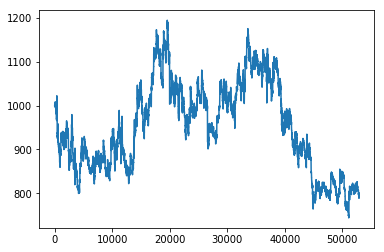

In [48]:
from strategies import MovingAverage
balance = MovingAverage().ma_cross_strategy(aapl_df["open"].values, 12, 26, family='sma')
plt.plot(range(len(balance)), balance)

In [109]:
from tools import Indicators

def backtest_macd(df, start_balance=1000, fee=0.1):
    
    price = df['close'].values
    MACD = df['MACD']

    balance = np.ones(len(price))
    balance[0] = start_balance
    hold  = 0

    for i in range(1, len(price)):  
        if hold == 0:
            if (MACD[i] > 0 and MACD[i-1] < 0): #buy condition
                hold = balance[i-1] / price[i] * (1.0 - fee/100.0)
            balance[i] = balance[i-1]
        else:
            balance[i] = hold * price[i] * (1.0 - fee/100.0)
            if (MACD[i] < 0 and MACD[i-1] > 0): #sell condition
                hold = 0
    return balance

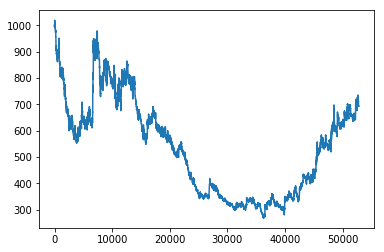

In [110]:
df = nvda_df.copy()

ewma = pd.Series.ewm
df['close_26EMA'] = ewma(df["close"], span=26).mean()
df['close_12EMA'] = ewma(df["close"], span=12).mean()

df['MACD'] = df['close_12EMA'] - df['close_26EMA']

balance = backtest_macd(df)
plt.plot(range(len(balance)), balance)

In [111]:
def getrsi(prices, n=14):
    deltas = np.diff(prices)
    seed = deltas[:n+1]
    up = seed[seed>=0].sum()/n
    down = -seed[seed<0].sum()/n
    rs = up/down
    rsi = np.zeros_like(prices)
    rsi[:n] = 100. - 100./(1.+rs)

    for i in range(n, len(prices)):
        delta = deltas[i-1]

        if delta>0:
            upval = delta
            downval = 0.
        else:
            upval = 0.
            downval = -delta

        up = (up*(n-1) + upval)/n
        down = (down*(n-1) + downval)/n

        rs = up/down
        rsi[i] = 100. - 100./(1.+rs)

    return rsi

In [112]:
from tools import Indicators

def backtest_rsi(df, start_balance=1000, fee=0.1):
    
    price = df['open'].values
    rsi = getrsi(df['open'].values, 14)

    balance = np.ones(len(price))
    balance[0] = start_balance
    hold  = 0

    for i in range(1, len(price)):
        if hold == 0:
            if (rsi[i] < 40): #buy condition
                hold = balance[i-1] / price[i] * (1.0 - fee/100.0)
            balance[i] = balance[i-1]
        else:
            balance[i] = hold * price[i] * (1.0 - fee/100.0)
            if (rsi[i] > 80): #sell condition
                hold = 0
        if (balance[i] < 300 and balance[i] > 10):
            print(price[i])
            print(price[i-1])
            print(i)
            break
    return balance

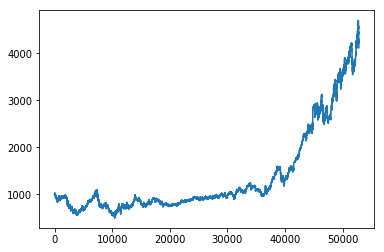

In [114]:
balance = backtest_rsi(df)
#print(balance[35000])
plt.plot(range(len(balance)), balance)
#plt.plot(range(len(balance)), df['open'].values)

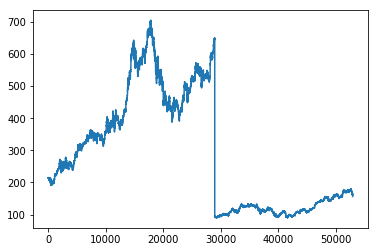

In [107]:
test = pd.read_csv(PATH_TO_DATA + "AAPL.csv", sep=',')
plt.plot(range(len(test['close'].values)), test['close'].values)